# 🧪 Classification : prédiction par tranches de prix

## 📦 Chargement des données

In [47]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from scipy import sparse
from collections import Counter

os.makedirs("models/classification", exist_ok=True)
os.makedirs("models/classification/train_test", exist_ok=True)

In [48]:
# Chargement des features et cible continue
X = sparse.load_npz("features/features_fiverr.npz")
y_prix = joblib.load("models/y_prix.pkl")

# 🎯 Découpage automatique en 4 tranches équilibrées (quartiles)
y_class = pd.qcut(y_prix, q=4, labels=False)

# ✅ Vérification de l’équilibre des classes
from collections import Counter
print("Distribution des tranches équilibrées :", Counter(y_class))

# ✂️ Séparation train / test
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)


Distribution des tranches équilibrées : Counter({0: 445, 2: 335, 3: 269, 1: 210})


# 🤖 Entraînement du modèle de classification
## Random Forest "balanced"

Classes prédites : [0 1 2 3] 

              precision    recall  f1-score   support

           0       0.67      0.77      0.72        87
           1       0.68      0.49      0.57        35
           2       0.62      0.49      0.55        81
           3       0.48      0.61      0.54        49

    accuracy                           0.61       252
   macro avg       0.61      0.59      0.59       252
weighted avg       0.62      0.61      0.61       252



['models/classification/random_forest_classifier_balanced.pkl']

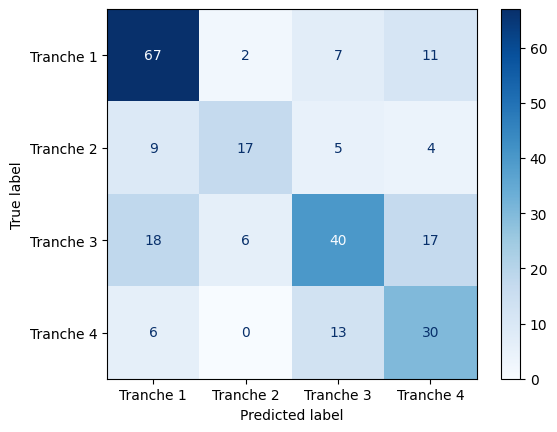

In [49]:
# Entraînement du modèle avec pondération automatique des classes
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Affichage des classes prédites
print("Classes prédites :", np.unique(y_pred),"\n")

# Affichage de la matrice de confusion : distribution des classes prédites
labels = ["Tranche 1", "Tranche 2", "Tranche 3", "Tranche 4"]
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=labels, cmap="Blues"
)

# Rapport de classification
print(classification_report(y_test, y_pred))

# Matrice de confusion
#disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
#plt.title("Matrice de confusion")
#plt.grid(False)
#plt.tight_layout()
#plt.show()

# Sauvegarde du modèle
joblib.dump(clf, "models/classification/random_forest_classifier_balanced.pkl")


In [50]:
# Affichage des classes prédites
print("Classes prédites :", np.unique(y_pred))

Classes prédites : [0 1 2 3]


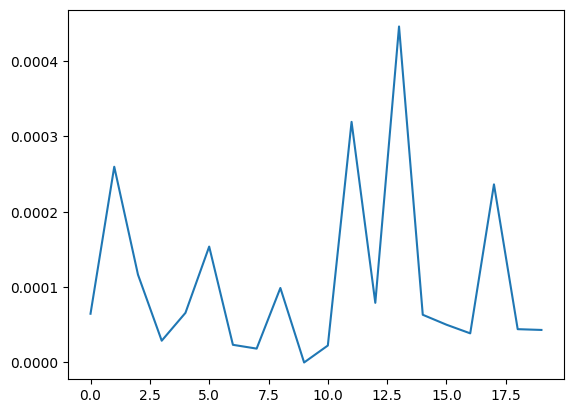

In [51]:
importances = clf.feature_importances_
plt.plot(importances[:20])

## 🔄 Comparaison avec d'autres modèles

### Modèle HistGradientBoostingClassifier 

🧠 HistGradientBoostingClassifier

              precision    recall  f1-score   support

   Tranche 1       0.74      0.74      0.74        87
   Tranche 2       0.68      0.60      0.64        35
   Tranche 3       0.70      0.67      0.68        81
   Tranche 4       0.52      0.61      0.56        49

    accuracy                           0.67       252
   macro avg       0.66      0.65      0.66       252
weighted avg       0.68      0.67      0.67       252



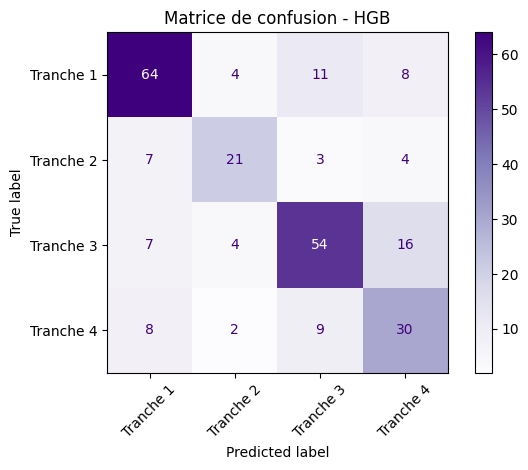

['models/classification/hgb_classifier.pkl']

In [52]:
from sklearn.ensemble import HistGradientBoostingClassifier

# Conversion car HGB ne supporte pas les matrices sparse
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Modèle
hgb_clf = HistGradientBoostingClassifier(random_state=42)
hgb_clf.fit(X_train_dense, y_train)
y_pred_hgb = hgb_clf.predict(X_test_dense)

# Rapport
print("🧠 HistGradientBoostingClassifier\n")
print(classification_report(y_test, y_pred_hgb, target_names=labels))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_hgb, display_labels=labels, cmap="Purples"
)
plt.title("Matrice de confusion - HGB")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sauvegarde du modèle
joblib.dump(hgb_clf, "models/classification/hgb_classifier.pkl")

### Modèle XGBClassifier 

🧠 XGBClassifier

              precision    recall  f1-score   support

   Tranche 1       0.76      0.71      0.73        87
   Tranche 2       0.71      0.63      0.67        35
   Tranche 3       0.71      0.69      0.70        81
   Tranche 4       0.55      0.67      0.61        49

    accuracy                           0.69       252
   macro avg       0.68      0.68      0.68       252
weighted avg       0.69      0.69      0.69       252



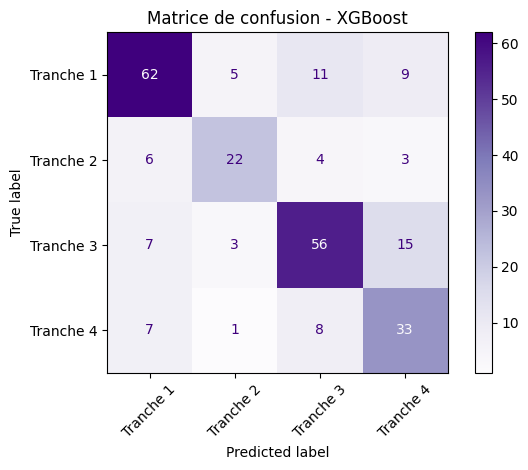

['models/classification/xgb_classifier.pkl']

In [53]:
# 📦 Import de XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# 🧠 Entraînement du modèle XGBoost
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42) #(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# 🔍 Prédictions
y_pred_xgb = xgb_clf.predict(X_test)

# 📈 Rapport de classification
print("🧠 XGBClassifier\n")
print(classification_report(
    y_test,
    y_pred_xgb,
    target_names=[f'Tranche {i+1}' for i in range(len(np.unique(y_train)))],
    zero_division=0
))

# 🧩 Matrice de confusion
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_xgb,
    display_labels=[f'Tranche {i+1}' for i in range(len(np.unique(y_train)))],
    cmap="Purples",
    xticks_rotation=45
)
plt.title("Matrice de confusion - XGBoost")
plt.grid(False)
plt.tight_layout()
plt.show()

# 💾 Sauvegarde du modèle
joblib.dump(xgb_clf, "models/classification/xgb_classifier.pkl")


## 📊 Rapport comparatif des modèles de classification

Nous avons testé plusieurs algorithmes de classification pour prédire des **tranches de prix** (issues de la variable continue `y_prix`, découpée selon les quartiles via `pd.qcut()`).

### 🎯 Objectif
Prédire la **tranche de prix** dans laquelle se situe un service Fiverr, en se basant sur les features vectorisées.

---

### 📌 Métriques comparées

| Modèle                     | Accuracy | Macro F1-Score | Observations principales |
|---------------------------|----------|----------------|---------------------------|
| **Random Forest**         | 0.61     | 0.59           | Bonne précision sur la première tranche, mais performances inégales sur les autres. |
| **HistGradientBoosting**  | 0.67     | 0.66           | Bon équilibre, modèle rapide et robuste. |
| **XGBoost Classifier**    | **0.69** | **0.68**       | Meilleure stabilité globale, bon rappel sur les tranches moyennes et élevées. |

---

### ✅ Choix du modèle

Nous retenons **XGBoost Classifier** comme modèle final de classification pour les raisons suivantes :
- Meilleur score global sur les métriques `accuracy` et `macro f1-score`
- Plus grande robustesse sur les classes minoritaires
- Capacité de généralisation légèrement supérieure

---

### 💾 Modèle sauvegardé

Le modèle final a été sauvegardé via :

```python
joblib.dump(xgb_clf, "models/classification/train_test/xgb_classifier.pkl")


In [54]:
from scipy import sparse
import joblib

# Sauvegarde des X_test (converti en dense si besoin)
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test
np.savez_compressed("models/classification/train_test/x_test_classification.npz", X_test_dense)

# Sauvegarde des y_test (tranches)
joblib.dump(y_test, "models/classification/train_test/y_test_classification.pkl")


['models/classification/train_test/y_test_classification.pkl']